# Relax Inc. Take-Home Challenge


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

In [3]:
users = pd.read_csv(r"C:/Users/omnia/Google Drive/Springboard/Assigments/Relax Inc. Take-Home Challenge/relax_challenge/takehome_users.csv", encoding="latin1")
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement = pd.read_csv(r"C:/Users/omnia/Google Drive/Springboard/Assigments/Relax Inc. Take-Home Challenge/relax_challenge/takehome_user_engagement.csv", encoding="latin1")
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [8]:
engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [9]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
engagement['time_stamp'] =pd.to_datetime(engagement['time_stamp'])

In [10]:
engagement = engagement.sort_values(by=['user_id', 'time_stamp'])

In [11]:
engagement['week_group'] = engagement.groupby('user_id')['time_stamp'].transform(lambda x: (x.diff().dt.days <= 7).cumsum())

In [12]:
engagement_agg = (engagement.groupby(['user_id', 'week_group']).size().reset_index(name="login_count"))

In [13]:
adopted_users = engagement_agg[engagement_agg['login_count'] >= 3]['user_id'].unique()

In [14]:
users['adopted_user'] = users['object_id'].isin(adopted_users).astype(int)
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])
users['time_since_creation'] = (users['last_session_creation_time'] - users['creation_time']).dt.days
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(-1)
users['was_invited'] = (users['invited_by_user_id']!= -1).astype(int)

In [15]:
users = pd.get_dummies(users, columns=['creation_source'], drop_first=True)

In [16]:
X = users.drop(['adopted_user', 'object_id', 'name', 'email', 'org_id', 'invited_by_user_id'], axis=1)
y = users['adopted_user']

In [17]:
if 'last_session_creation_time' in X.columns:
    X['last_session_creation_time'] = (X['last_session_creation_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
if 'creation_time' in X.columns:
    X['creation_time'] = (X['creation_time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [18]:
X = X.astype({col: 'int' for col in X.select_dtypes(include=['bool']).columns})

In [19]:
print(X.isnull().sum())

creation_time                         0
last_session_creation_time            0
opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
time_since_creation                   0
was_invited                           0
creation_source_ORG_INVITE            0
creation_source_PERSONAL_PROJECTS     0
creation_source_SIGNUP                0
creation_source_SIGNUP_GOOGLE_AUTH    0
dtype: int64


In [20]:
print(X.dtypes)

creation_time                         int64
last_session_creation_time            int64
opted_in_to_mailing_list              int64
enabled_for_marketing_drip            int64
time_since_creation                   int64
was_invited                           int32
creation_source_ORG_INVITE            int32
creation_source_PERSONAL_PROJECTS     int32
creation_source_SIGNUP                int32
creation_source_SIGNUP_GOOGLE_AUTH    int32
dtype: object


In [21]:
# Train_Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
rand_model = RandomForestClassifier(random_state=42)
rand_model.fit(X_train, y_train)
rand_pred = rand_model.predict(X_test) 

print("Classification Report:")
print(classification_report(y_test, rand_pred))
print(f"Accuracy: {accuracy_score(y_test, rand_pred) : .2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3165
           1       0.74      0.80      0.77       435

    accuracy                           0.94      3600
   macro avg       0.86      0.88      0.87      3600
weighted avg       0.94      0.94      0.94      3600

Accuracy:  0.94


In [23]:
# Feature importance
feature_importance = pd.DataFrame({'Feature' : X.columns, 'Importance': rand_model.feature_importances_}).sort_values(by='Importance', ascending=False)

In [24]:
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                              Feature  Importance
4                 time_since_creation    0.590011
1          last_session_creation_time    0.238981
0                       creation_time    0.130986
2            opted_in_to_mailing_list    0.008803
3          enabled_for_marketing_drip    0.007415
6          creation_source_ORG_INVITE    0.006652
5                         was_invited    0.004659
8              creation_source_SIGNUP    0.004371
9  creation_source_SIGNUP_GOOGLE_AUTH    0.004170
7   creation_source_PERSONAL_PROJECTS    0.003951


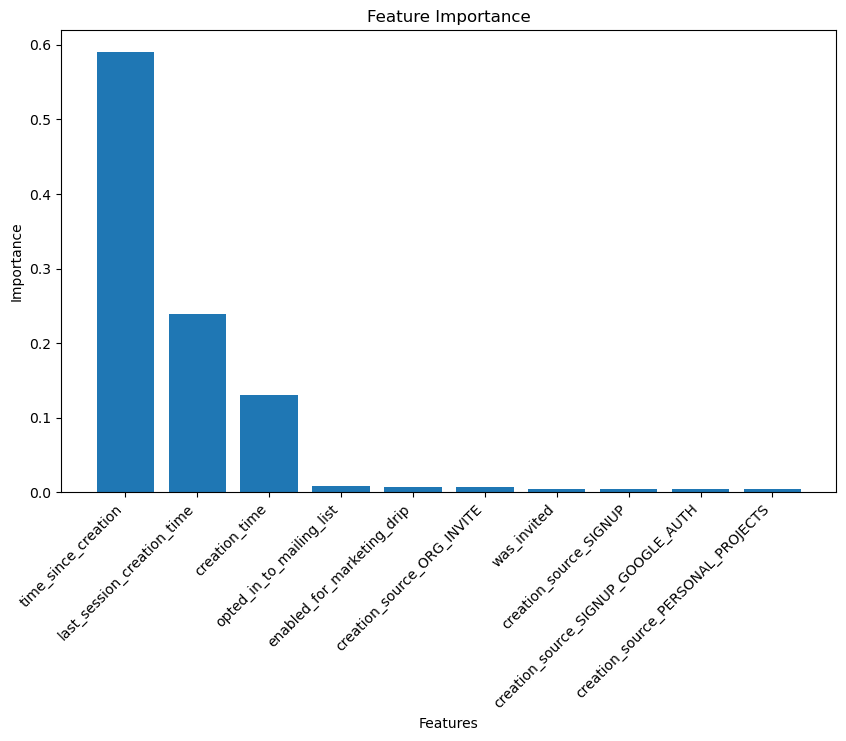

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

Key Insights:

1. time_since_creation Dominates:

    With an importance of ~59%, this feature overwhelmingly influences the model. It suggests that how long a user has been on the platform is crucial in determining adoption.

2. Recency is Important (last_session_creation_time):

    Users with recent activity are more likely to become adopted, highlighting the importance of consistent engagement.

3. Signup and Invitation Sources Have Limited Influence:

    Features like creation_source and was_invited have minimal impact. This suggests that how users join the platform (invite, direct signup, Google authentication) is less important than their behavior after joining.

4. Marketing Campaigns Have Some Influence:

    opted_in_to_mailing_list and enabled_for_marketing_drip have small contributions, meaning these might nudge adoption but are not strong drivers.